## 📚 ***IMPORTING DATA & PYTHON PACKAGES*** 

### -Load and Combining the Reservior CSVs, Rainfall & Temperature Data's
### -Getting the Combined Dataset

In [1]:
import pandas as pd
import numpy as np
import glob
import os

# --- 1. Load and combine the reservoir CSVs ---
# Using the glob pattern you confirmed
reservoir_files = glob.glob('data/Reservoir*.csv') 
df_list = [pd.read_csv(file) for file in reservoir_files]
df_reservoir = pd.concat(df_list, ignore_index=True)

df_reservoir.columns = ['Date', 'Storage_BCM']
df_reservoir['Date'] = pd.to_datetime(df_reservoir['Date'])
df_reservoir = df_reservoir.sort_values(by='Date').reset_index(drop=True)


# --- 2. Function to read BINARY weather data with DYNAMIC grid sizes ---
TARGET_LAT = 22.6
TARGET_LON = 82.6

def get_weather_data_for_location(date, data_type_prefix, data_folder='data/'):
    """
    Reads IMD binary .grd files, handling different grid sizes for different data types.
    """
    if data_type_prefix == 'Rainfall':
        filename = os.path.join(data_folder, f'Rainfall_ind{date.year}_rfp25.grd')
        # --- FIX: Set grid parameters for RAINFALL data ---
        lat_start, lon_start = 6.5, 66.5
        lat_step, lon_step = 0.25, 0.25
        num_lats, num_lons = 129, 135
    elif data_type_prefix == 'Maxtemp':
        filename = os.path.join(data_folder, f'Maxtemp_MaxT_{date.year}.GRD')
        # --- FIX: Set grid parameters for TEMPERATURE data ---
        lat_start, lon_start = 7.5, 67.5
        lat_step, lon_step = 1.0, 1.0
        num_lats, num_lons = 31, 31
    else:
        return np.nan
    
    if not os.path.exists(filename):
        return np.nan
    
    lat_index = int((TARGET_LAT - lat_start) / lat_step)
    lon_index = int((TARGET_LON - lon_start) / lon_step)
    
    try:
        data = np.fromfile(filename, dtype=np.float32)
        data = data.reshape(-1, num_lats, num_lons) # Reshape using the correct dimensions
        day_of_year = date.dayofyear - 1
        value = data[day_of_year, lat_index, lon_index]
        return value if value != -999.0 else np.nan
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return np.nan

# --- 3. Build the final master dataset ---
print("Extracting daily weather data...")

df_reservoir['Rainfall_mm'] = df_reservoir['Date'].apply(
    lambda date: get_weather_data_for_location(date, 'Rainfall')
)
df_reservoir['Temp_C'] = df_reservoir['Date'].apply(
    lambda date: get_weather_data_for_location(date, 'Maxtemp')
)

# --- 4. Final Merge and Clean ---
df_master = df_reservoir.set_index('Date')

# Drop rows where we have reservoir data but no weather data
df_master.dropna(subset=['Rainfall_mm', 'Temp_C'], inplace=True, how='all')
# Forward-fill any remaining gaps
df_master.ffill(inplace=True)


print("\n--- Master Dataset Ready ---")
df_master.info()
print("\nMaster Dataset Head:")
print(df_master.head())
print("\nMaster Dataset Tail:")
print(df_master.tail())

Extracting daily weather data...

--- Master Dataset Ready ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2010-01-01 to 2024-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Storage_BCM  5479 non-null   float64
 1   Rainfall_mm  5479 non-null   float64
 2   Temp_C       5479 non-null   float64
dtypes: float64(3)
memory usage: 171.2 KB

Master Dataset Head:
            Storage_BCM  Rainfall_mm     Temp_C
Date                                           
2010-01-01         6.17          0.0  22.820000
2010-01-02         6.17          0.0  23.510000
2010-01-03         6.15          0.0  23.440001
2010-01-04         6.14          0.0  24.620001
2010-01-05         6.12          0.0  22.980000

Master Dataset Tail:
            Storage_BCM  Rainfall_mm     Temp_C
Date                                           
2024-12-27         1.41     0.000000  29.990520
2024-12-28         1.41     0.000000 

## ***Exploratory Data Analysis (EDA)*** 📊

#### ***1. Plot the Time Series Data***

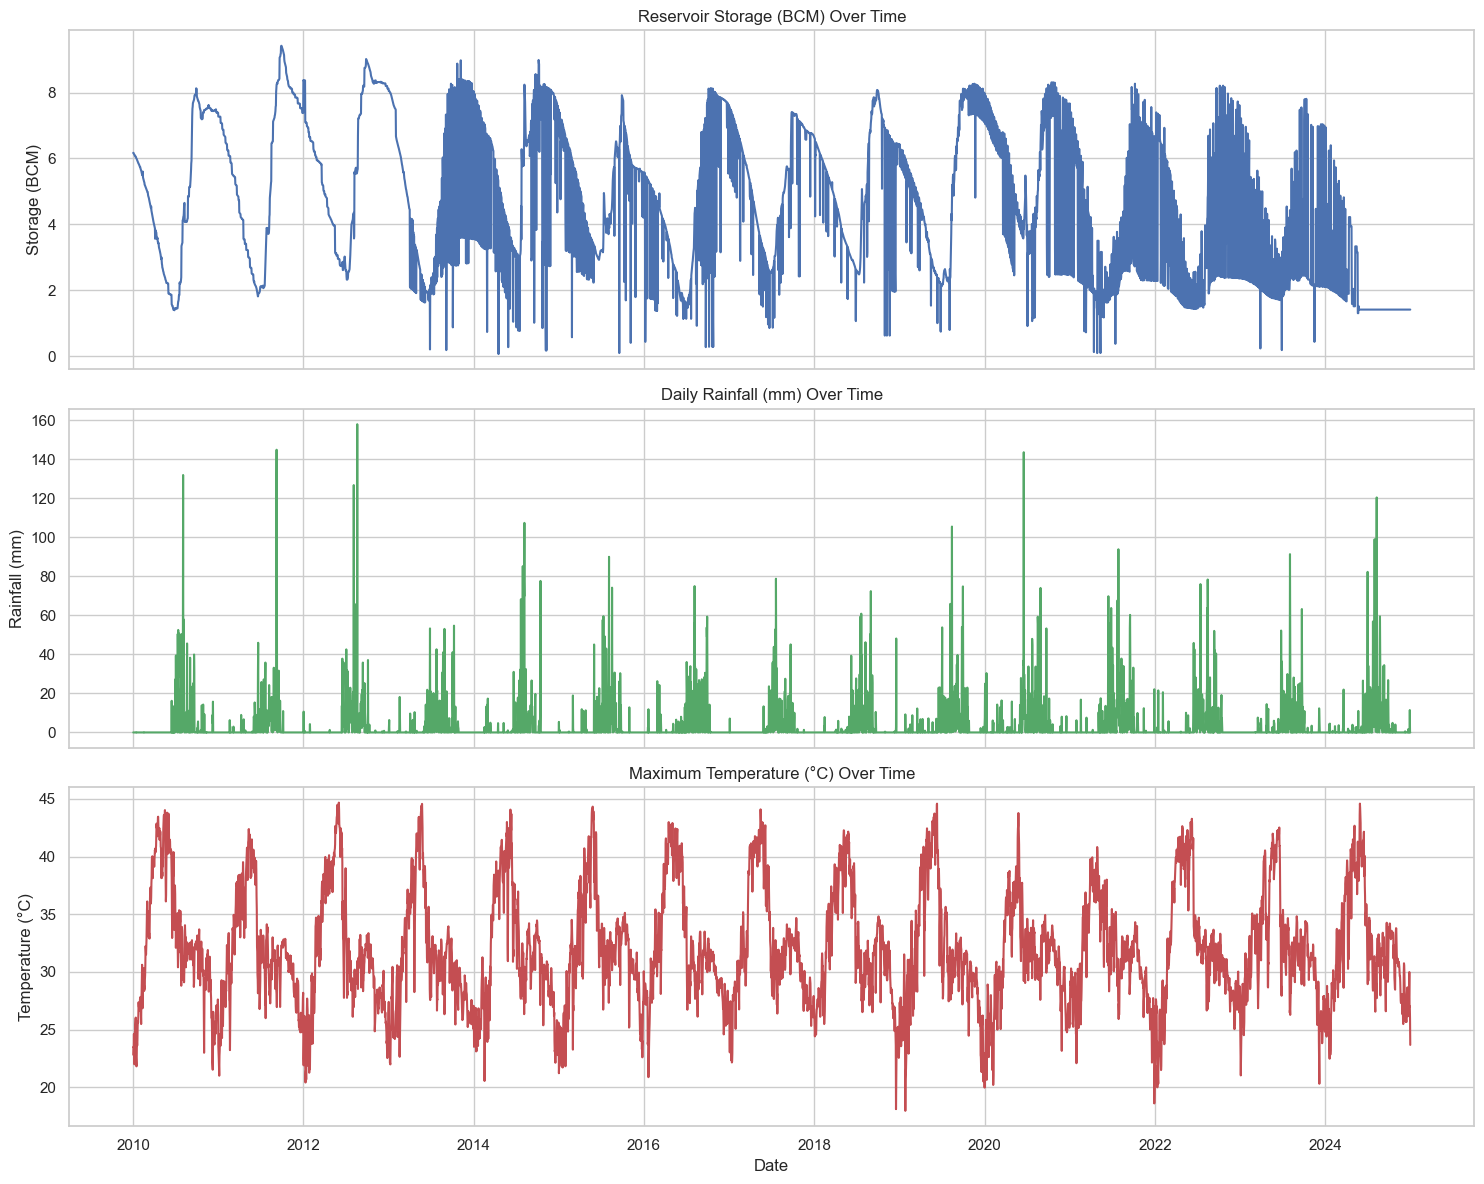

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Create subplots to visualize all variables
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot Storage
axes[0].plot(df_master.index, df_master['Storage_BCM'], color='b')
axes[0].set_title('Reservoir Storage (BCM) Over Time')
axes[0].set_ylabel('Storage (BCM)')

# Plot Rainfall as a line plot instead of a bar chart
axes[1].plot(df_master.index, df_master['Rainfall_mm'], color='g')
axes[1].set_title('Daily Rainfall (mm) Over Time')
axes[1].set_ylabel('Rainfall (mm)')

# Plot Temperature
axes[2].plot(df_master.index, df_master['Temp_C'], color='r')
axes[2].set_title('Maximum Temperature (°C) Over Time')
axes[2].set_ylabel('Temperature (°C)')

plt.xlabel('Date')
plt.tight_layout()
plt.savefig('images/Reservoir_Weather_Data_Visualization.png')
plt.show()

#### ***2. Analyze Correlations with a Heatmap***

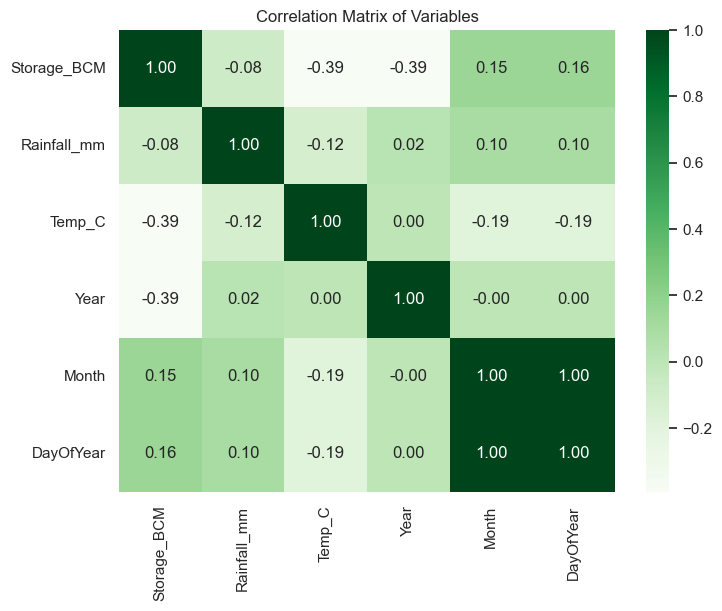

In [22]:
# Calculate the correlation matrix
correlation_matrix = df_master.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.savefig('images/Heatmap.png')
plt.show()

#### ***3. Decompose the Time Series***

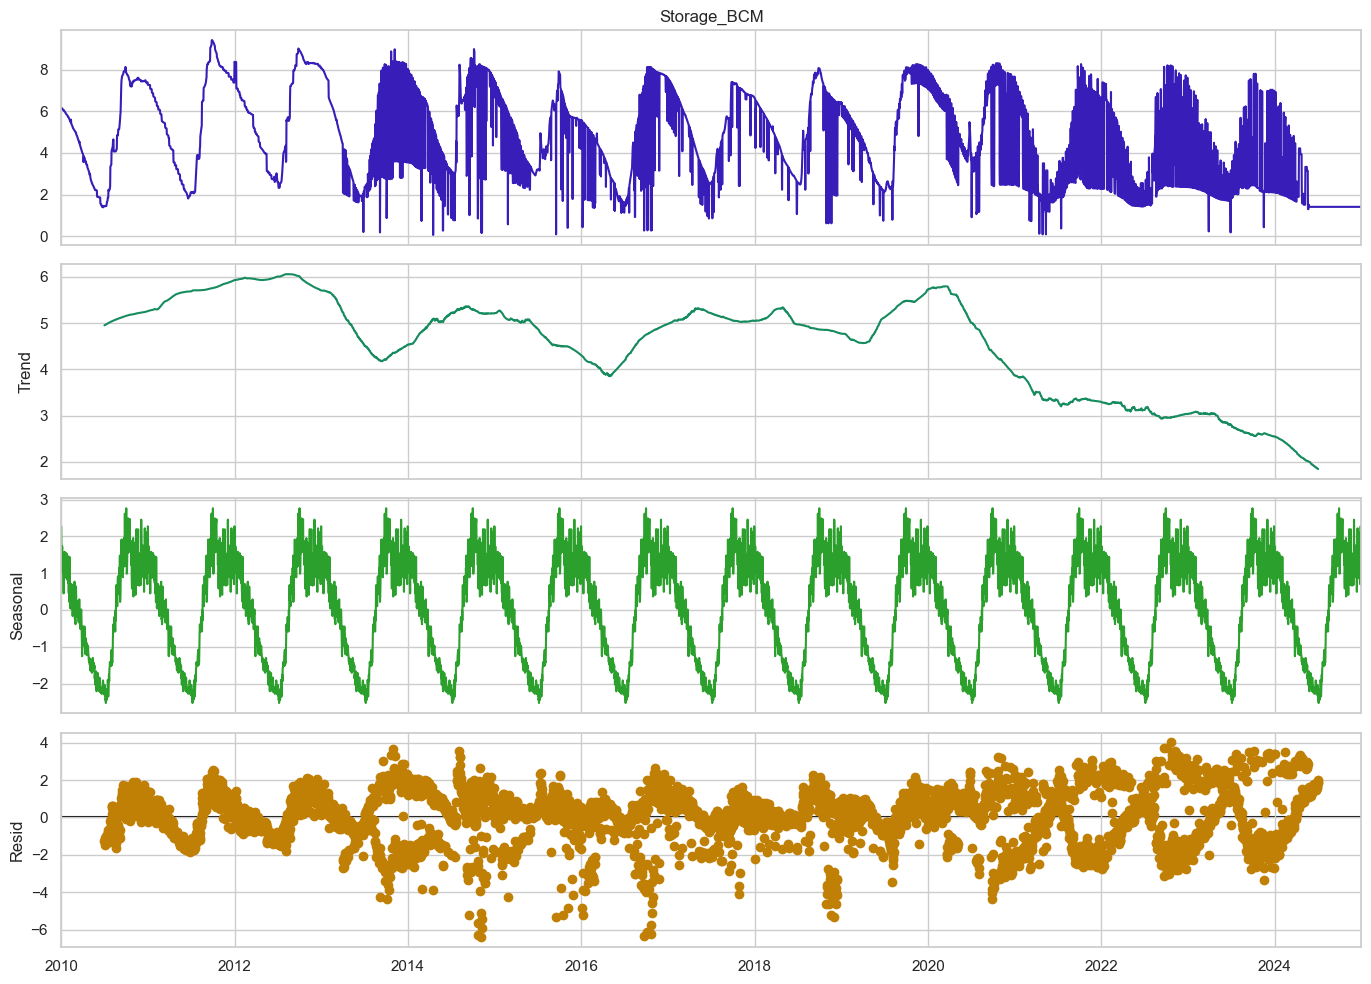

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'Storage_BCM' time series
# The period is 365 because we expect an annual seasonal cycle
result = seasonal_decompose(df_master['Storage_BCM'], model='additive', period=365)

# Plot the decomposed components
fig = result.plot()
fig.set_size_inches(14, 10)
colors = ["#391db8", "#168b5e", '#2ca02c', "#c07f05"]  # Custom colors for each component

for i, ax in enumerate(fig.axes):
    ax.lines[0].set_color(colors[i])

plt.tight_layout()
plt.savefig('images/Decomposed_Time_series_of_StorageBCM.png')
plt.show()

## ***Feature Engineering & Preprocessing*** ⚛️

#### ***1. Feature Engineering***

In [5]:
# Create year, month, and day-of-year features
df_master['Year'] = df_master.index.year
df_master['Month'] = df_master.index.month
df_master['DayOfYear'] = df_master.index.dayofyear

print("DataFrame with new features:")
print(df_master.head())

DataFrame with new features:
            Storage_BCM  Rainfall_mm     Temp_C  Year  Month  DayOfYear
Date                                                                   
2010-01-01         6.17          0.0  22.820000  2010      1          1
2010-01-02         6.17          0.0  23.510000  2010      1          2
2010-01-03         6.15          0.0  23.440001  2010      1          3
2010-01-04         6.14          0.0  24.620001  2010      1          4
2010-01-05         6.12          0.0  22.980000  2010      1          5


#### ***2. Train-Test Split***

In [6]:
# We will use data up to the end of 2023 to train, and test on 2024
train_df = df_master.loc['2010-01-01':'2023-12-31']
test_df = df_master.loc['2024-01-01':]

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (5113, 6)
Testing data shape: (366, 6)


#### ***3. Data Scaling***

In [7]:
from sklearn.preprocessing import MinMaxScaler

# scale all columns
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
train_scaled = scaler.fit_transform(train_df)

# Only transform the test data using the already-fitted scaler
test_scaled = scaler.transform(test_df)

# For clarity, let's put the scaled data back into DataFrames
train_scaled_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
test_scaled_df = pd.DataFrame(test_scaled, index=test_df.index, columns=test_df.columns)

print("\nScaled Training Data Head:")
print(train_scaled_df.head())


Scaled Training Data Head:
            Storage_BCM  Rainfall_mm    Temp_C  Year  Month  DayOfYear
Date                                                                  
2010-01-01     0.652778          0.0  0.182062   0.0    0.0   0.000000
2010-01-02     0.652778          0.0  0.207880   0.0    0.0   0.002740
2010-01-03     0.650641          0.0  0.205261   0.0    0.0   0.005479
2010-01-04     0.649573          0.0  0.249413   0.0    0.0   0.008219
2010-01-05     0.647436          0.0  0.188049   0.0    0.0   0.010959


## ***Building the SARIMA Model*** 🧠

#### ***1. Finding the Best Model and Fitting***

In [8]:
import pmdarima as pm

# 1. Resample the master dataframe to a weekly frequency
# We use .mean() to get the average value for each week
df_weekly = df_master.resample('W').mean()

print("--- Resampled Weekly Data ---")
print(df_weekly.head())

# 2. Create new training and testing sets from the weekly data
train_weekly = df_weekly.loc['2010-01-01':'2023-12-31']
test_weekly = df_weekly.loc['2024-01-01':]

# 3. Run auto_arima on the weekly data
# This will be much faster because m=52 instead of m=365
sarima_model_weekly = pm.auto_arima(train_weekly['Storage_BCM'],
                                  seasonal=True,
                                  m=52, # Weekly seasonality
                                  trace=True,
                                  error_action='ignore',  
                                  suppress_warnings=True, 
                                  stepwise=True)

# 4. Print the summary
print(sarima_model_weekly.summary())

--- Resampled Weekly Data ---
            Storage_BCM  Rainfall_mm     Temp_C    Year  Month  DayOfYear
Date                                                                     
2010-01-03     6.163333      0.00000  23.256667  2010.0    1.0        2.0
2010-01-10     6.100000      0.00000  23.988571  2010.0    1.0        7.0
2010-01-17     6.010000      0.02017  23.612857  2010.0    1.0       14.0
2010-01-24     5.890000      0.00000  25.420000  2010.0    1.0       21.0
2010-01-31     5.780000      0.00000  26.932857  2010.0    1.0       28.0
Performing stepwise search to minimize aic


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' wa

 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=14.25 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1558.938, Time=0.08 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1533.479, Time=1.81 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1533.747, Time=2.58 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1556.969, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1550.618, Time=0.06 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=1533.777, Time=12.78 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=5.52 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=1535.276, Time=1.97 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=79.25 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=1546.286, Time=1.36 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=1531.713, Time=2.25 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=1551.622, Time=0.07 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[52] intercept   : AIC=1530.185, Time=13.96 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=73.56 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.95 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,0)[52] intercept   : AIC=1532.096, Time=18.76 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[52] intercept   : AIC=1532.067, Time=27.67 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=1531.148, Time=20.63 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,0)[52] intercept   : AIC=1534.067, Time=57.66 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[52]             : AIC=1528.210, Time=6.15 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[52]             : AIC=1529.744, Time=0.78 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[52]             : AIC=inf, Time=79.80 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[52]             : AIC=inf, Time=4.82 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[52]             : AIC=1531.801, Time=6.43 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,0)[52]             : AIC=1530.122, Time=8.11 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[52]             : AIC=1530.093, Time=11.42 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[52]             : AIC=1529.174, Time=9.70 sec


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,0)[52]             : AIC=1532.093, Time=17.68 sec

Best model:  ARIMA(2,1,0)(2,0,0)[52]          
Total fit time: 486.322 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  731
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 52)   Log Likelihood                -759.105
Date:                            Sat, 19 Jul 2025   AIC                           1528.210
Time:                                    20:56:16   BIC                           1551.175
Sample:                                01-03-2010   HQIC                          1537.070
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

#### ***2. Generating Forecast (Weekly Model)***

In [9]:
# The number of periods to forecast is the length of our weekly test set
n_periods = len(test_weekly)

# Generate the forecast using the weekly model
sarima_forecast_weekly = sarima_model_weekly.predict(n_periods=n_periods)

# Put the forecast into a pandas Series with the correct weekly dates
sarima_forecast_weekly_series = pd.Series(sarima_forecast_weekly, index=test_weekly.index)

print("\n--- Weekly SARIMA Forecast ---")
print(sarima_forecast_weekly_series.head())


--- Weekly SARIMA Forecast ---
Date
2024-01-07    2.929881
2024-01-14    2.913628
2024-01-21    3.036935
2024-01-28    2.954778
2024-02-04    2.741485
Freq: W-SUN, dtype: float64


c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## ***Building the LSTM Model*** 🧠

#### ***1. Prepare the Data into Sequences***

In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define how many past weeks the model should look at
n_steps = 4 

# Use the scaled weekly dataframes we created in Feature Engineering
train_weekly_scaled = scaler.transform(train_weekly)
test_weekly_scaled = scaler.transform(test_weekly)

# Create sequences for training and testing
# Note: We are using all columns (including rainfall, temp) to predict the last column (Storage_BCM)
X_train, y_train = create_sequences(train_weekly_scaled, n_steps)
X_test, y_test = create_sequences(test_weekly_scaled, n_steps)

print(f"Training sequences shape: {X_train.shape}")
print(f"Test sequences shape: {X_test.shape}")

Training sequences shape: (727, 4, 5)
Test sequences shape: (49, 4, 5)


#### ***2. Build the LSTM Model Architecture***

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# The number of features our model will use as input
n_features = X_train.shape[2]

# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model's architecture
model.summary()

c:\PROJECTSSS\chhattisgarh_water_model\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 50)          │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

#### ***3. Train the Model***

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2268 - val_loss: 0.0597
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0674 - val_loss: 0.0529
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0465 - val_loss: 0.0208
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291 - val_loss: 0.0045
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - val_loss: 0.0062
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - val_loss: 0.0043
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0199 - val_loss: 0.0040
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0186 - val_loss: 0.0041
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0087
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - val_loss: 0.0037
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0158 - val_loss: 0.0094
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_l

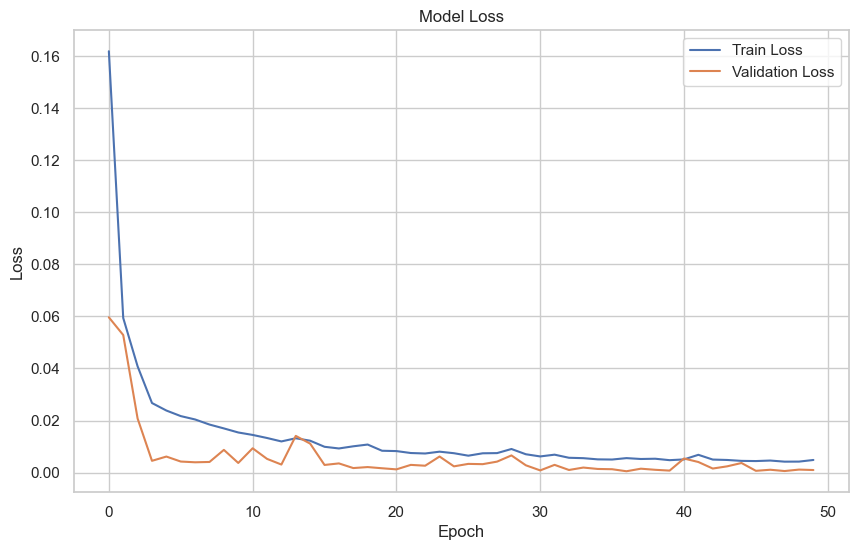

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## ***Evaluation and Comparison 🏆***

#### ***1. Generate LSTM Predictions and Un-scale the Data***

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Get predictions from the LSTM model
lstm_predictions_scaled = model.predict(X_test)

# 2. Un-scale the predictions and the actual test values
# We need to create a dummy array with the same number of features as the scaler
# Then, we place our predictions into the correct column and inverse_transform

# Create a dummy array for the predictions
dummy_predictions = np.zeros((len(lstm_predictions_scaled), train_weekly_scaled.shape[1]))
dummy_predictions[:, -1] = lstm_predictions_scaled.ravel() # Put predictions in the last column
lstm_predictions_unscaled = scaler.inverse_transform(dummy_predictions)[:, -1]

# Create a dummy array for the actual values (y_test)
dummy_y_test = np.zeros((len(y_test), train_weekly_scaled.shape[1]))
dummy_y_test[:, -1] = y_test.ravel() # Put actuals in the last column
y_test_unscaled = scaler.inverse_transform(dummy_y_test)[:, -1]

# 3. Create a pandas Series for the LSTM forecast for easier plotting
# Note: The LSTM predictions will be shorter than the test set by n_steps
lstm_forecast_index = test_weekly.index[n_steps:]
lstm_forecast_series = pd.Series(lstm_predictions_unscaled, index=lstm_forecast_index)

print("--- Unscaled LSTM Forecast ---")
print(lstm_forecast_series.head())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
--- Unscaled LSTM Forecast ---
Date
2024-02-04    45.855071
2024-02-11    50.318013
2024-02-18    53.692903
2024-02-25    60.016381
2024-03-03    67.980869
Freq: W-SUN, dtype: float64


#### ***2. Calculate Evaluation Metrics***

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- SARIMA Evaluation ---
# We need to compare it against the portion of the test set it can predict
sarima_rmse = np.sqrt(mean_squared_error(test_weekly['Storage_BCM'], sarima_forecast_weekly_series))
sarima_mae = mean_absolute_error(test_weekly['Storage_BCM'], sarima_forecast_weekly_series)

# --- LSTM Evaluation ---
# We compare the unscaled predictions against the unscaled true values
lstm_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions_unscaled))
lstm_mae = mean_absolute_error(y_test_unscaled, lstm_predictions_unscaled)

print("--- Model Performance Metrics ---")
print(f"SARIMA Model RMSE: {sarima_rmse:.3f}")
print(f"SARIMA Model MAE:  {sarima_mae:.3f}")
print("-" * 20)
print(f"LSTM Model RMSE:   {lstm_rmse:.3f}")
print(f"LSTM Model MAE:    {lstm_mae:.3f}")

--- Model Performance Metrics ---
SARIMA Model RMSE: 1.021
SARIMA Model MAE:  0.920
--------------------
LSTM Model RMSE:   11.528
LSTM Model MAE:    9.083


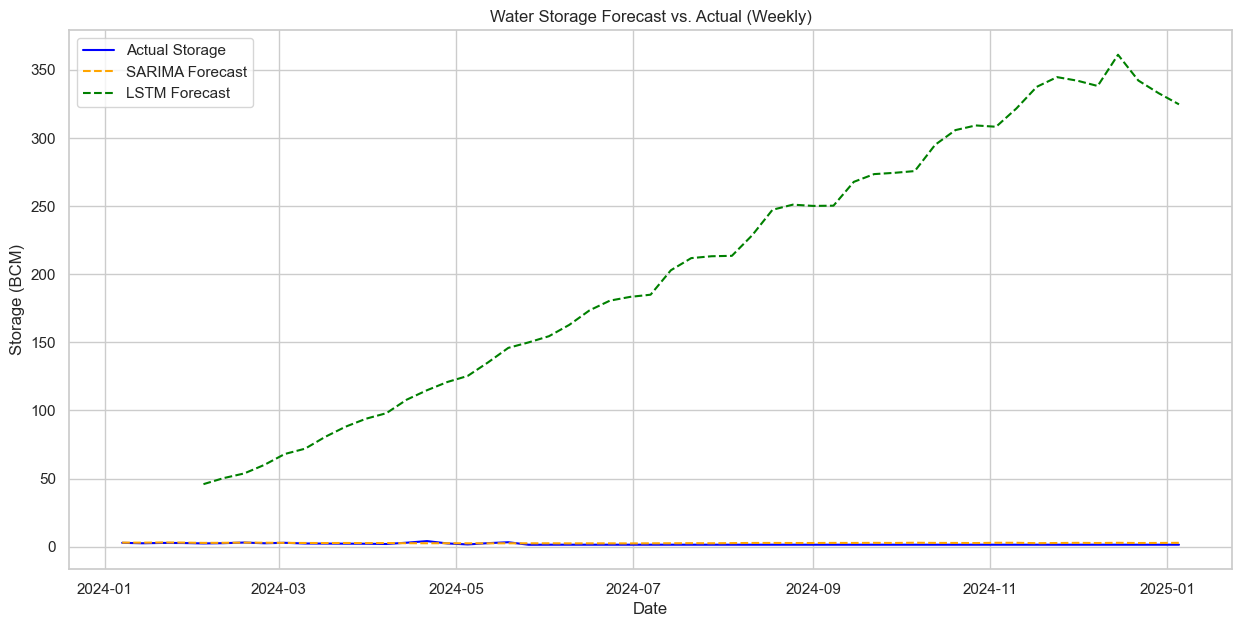

In [19]:
plt.figure(figsize=(15, 7))

# Plot actual values
plt.plot(test_weekly.index, test_weekly['Storage_BCM'], label='Actual Storage', color='blue')

# Plot SARIMA forecast
plt.plot(sarima_forecast_weekly_series.index, sarima_forecast_weekly_series, label='SARIMA Forecast', color='orange', linestyle='--')

# Plot LSTM forecast
plt.plot(lstm_forecast_series.index, lstm_forecast_series, label='LSTM Forecast', color='green', linestyle='--')

plt.title('Water Storage Forecast vs. Actual (Weekly)')
plt.ylabel('Storage (BCM)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.savefig('images/final_forecast_comparison.png')
plt.show()

## ***Saving The Models (Models folder)*** ⚛️

In [24]:
import joblib

# --- Save the SARIMA model ---
joblib.dump(sarima_model_weekly, 'models/sarima_model.pkl')

# --- Save the LSTM model ---
model.save('models/lstm_model.keras')

print("Models have been saved successfully to the 'models' folder.")

Models have been saved successfully to the 'models' folder.
